# Combination of topic modelling and word embeddings for the identification of statistical datasets

* Carry-out topic modelling with a large enough corpus (Statistics Explained articles and Statistics Explained Glossary articles) and a large number of topics (1000) and extract **significant** (lemmatized) keywords. The objectives are two: 
    * to cover the whole corpus and thus the "correlated" datasets at a high granularity, 
    * avoid using common ("dominating") words in the matches with the user's query.  

* Enhance these keywords with their closest terms from the word embeddings created exclusively from Eurostat's content. The total large number of keywords can then differentiate the datasets.  

* Match the (similarly enhanced) sentence(s) entered in the query with datasets, based on the number of keywords found in the datasets (simple or full descriptions).  

* Put **first priority** to the matches with words in the enhanced topic modelling dictionary and **second** to the matches with any other words, to avoid "dominating" terms. 

* The union of the topic modelling keywords found in the datasets descriptions (enhanced or not) can also be used as multi-labels in a multi-label classification algorithm such as BERT.

### The run time can be reduced by loading (rather than re-creating) the topic modelling LDA model and by de-activating the coherence calculations

In [1]:
import gensim
import pandas as pd
import numpy as np

import re

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

import pyodbc



### Statistics Explained Glossary articles  

* Definitions from dat_glossary.
* Titles from dat_link_info (with resource_information_id=1, i.e. Eurostat, see ESTAT.V1.mod_resource_information).
* Match above on id.


In [2]:
c = pyodbc.connect('DSN=Virtuoso All;DBA=ESTAT;UID=xxxxx;PWD=xxxxx')
cursor = c.cursor()

SQLCommand = """SELECT T1.id, T1.definition, T2.title 
                FROM ESTAT.V1.dat_glossary as T1 
                INNER JOIN ESTAT.V1.dat_link_info as T2  
                  ON T1.id=T2.id 
                WHERE T2.resource_information_id=1 """

GL_df = pd.read_sql(SQLCommand,c)
GL_df = GL_df[['id', 'title', 'definition']]

GL_df

,id,title,definition
0,1,Accident at work,An accident at work in the framework ...
1,5,Fatal accident at work,A fatal accident at work refers to an...
2,6,Non-fatal accident at work,A non-fatal accident at work is...
3,8,Aggregate demand,Aggregate demand is the total amount of ...
4,9,Goods and services account,The goods and services account shows ...
...,...,...,...
1309,2319,Actual individual consumption (AIC),"Actual individual consumption , abbrevia..."
1310,2321,Activity rate,Activity rate is the percentage of a...
1311,2322,Activation policies,The activation policies are policies ...
1312,2324,Active enterprises - FRIBS,"<Brief user-oriented definition, one or a fe..."


### Delete records with empty definitions and carry out data cleansing


In [3]:

GL_df = GL_df.dropna(axis=0,how='any')
print(GL_df.isnull().sum())
GL_df.reset_index(drop=True, inplace=True)

import unicodedata as ud

def clean(x, quotes=True):
    if pd.isnull(x): return x  
    x = x.strip()
    
    ## make letter-question mark-letter -> letter-quote-space-letter !!! but NOT in the lists of URLs!!!
    if quotes:
        x = re.sub(r'([A-Za-z])\?([A-Za-z])','\\1\' \\2',x) 
    
    ## make letter-question mark-space lower case letter letter-quote-space letter
    x = re.sub(r'([A-Za-z])\? ([a-z])','\\1\' \\2',x) 

    ## delete ,000 commas in numbers    
    x = re.sub(r'\b(\d+),(\d+)\b','\\1\\2',x) ## CORRECTED
    
    ## delete  000 spaces in numbers
    x = re.sub(r'\b(\d+) (\d+)\b','\\1\\2',x) ## CORRECTED
    
    ## remove more than one spaces
    x = re.sub(r' +', ' ',x)
    
    ## remove start and end spaces
    x = re.sub(r'^ +| +$', '',x,flags=re.MULTILINE) 
    
    ## space-comma -> comma
    x = re.sub(r' \,',',',x)
    
    ## space-dot -> dot
    x = re.sub(r' \.','.',x)
    
    ## x = re.sub(r'a.{2}',"'",x) ### !!! NEW: single quotes are read as: aXX
    
    x = x.encode('latin1').decode('utf-8') ## a\x80\x99
    x = ud.normalize('NFKD',x).encode('ascii', 'ignore').decode()
    
    return x


GL_df['title'] = GL_df['title'].apply(clean)
GL_df['title'] = GL_df['title'].apply(lambda x: re.sub(r'\?','-',x)) ## also replace question marks by dashes
GL_df['definition'] = GL_df['definition'].apply(clean)

GL_df

id            0
title         0
definition    0
dtype: int64


,id,title,definition
0,1,Accident at work,An accident at work in the framework of the ad...
1,5,Fatal accident at work,A fatal accident at work refers to an accident...
2,6,Non-fatal accident at work,A non-fatal accident at work is an accident wh...
3,8,Aggregate demand,Aggregate demand is the total amount of goods ...
4,9,Goods and services account,The goods and services account shows the balan...
...,...,...,...
1309,2319,Actual individual consumption (AIC),"Actual individual consumption, abbreviated as ..."
1310,2321,Activity rate,Activity rate is the percentage of active pers...
1311,2322,Activation policies,The activation policies are policies designed ...
1312,2324,Active enterprises - FRIBS,"<Brief user-oriented definition, one or a few ..."


### Delete "special" records

* i.e. redirections.



In [4]:
## Drop The records with definitions "The revision ..." and "Redirect to ..." 

idx = GL_df[GL_df['definition'].str.startswith('The revision #')].index
print(idx)
GL_df.drop(idx , inplace=True)
idx = GL_df[GL_df['definition'].str.startswith('Redirect to')].index
print(idx)
GL_df.drop(idx , inplace=True)
GL_df.reset_index(drop=True, inplace=True)
GL_df

Int64Index([ 230,  292,  384,  386,  433,  436,  438,  439,  504,  519,  530,
             557,  588,  729,  742,  775,  826,  889,  891,  912,  960,  961,
             969, 1003, 1007, 1133, 1144, 1182, 1231],
           dtype='int64')
Int64Index([], dtype='int64')


,id,title,definition
0,1,Accident at work,An accident at work in the framework of the ad...
1,5,Fatal accident at work,A fatal accident at work refers to an accident...
2,6,Non-fatal accident at work,A non-fatal accident at work is an accident wh...
3,8,Aggregate demand,Aggregate demand is the total amount of goods ...
4,9,Goods and services account,The goods and services account shows the balan...
...,...,...,...
1280,2319,Actual individual consumption (AIC),"Actual individual consumption, abbreviated as ..."
1281,2321,Activity rate,Activity rate is the percentage of active pers...
1282,2322,Activation policies,The activation policies are policies designed ...
1283,2324,Active enterprises - FRIBS,"<Brief user-oriented definition, one or a few ..."


### Create column "raw content" with the titles and the definitions


In [5]:
GL_df['raw content'] = GL_df['title'] +'. '+GL_df['definition']
#GL_df['source'] = 'GL'
#GL_df = GL_df[['id','title','raw content','source']]
GL_df = GL_df[['id','title','raw content']]
GL_df

,id,title,raw content
0,1,Accident at work,Accident at work. An accident at work in the f...
1,5,Fatal accident at work,Fatal accident at work. A fatal accident at wo...
2,6,Non-fatal accident at work,Non-fatal accident at work. A non-fatal accide...
3,8,Aggregate demand,Aggregate demand. Aggregate demand is the tota...
4,9,Goods and services account,Goods and services account. The goods and serv...
...,...,...,...
1280,2319,Actual individual consumption (AIC),Actual individual consumption (AIC). Actual in...
1281,2321,Activity rate,Activity rate. Activity rate is the percentage...
1282,2322,Activation policies,Activation policies. The activation policies a...
1283,2324,Active enterprises - FRIBS,Active enterprises - FRIBS. <Brief user-orient...


### Statistics Explained articles

* IDs, titles from dat_link_info, with resource_information_id=1, i.e. Eurostat (see ESTAT.V1.mod_resource_information) and matching IDs from dat_article.
* Carry out data cleansing on titles.

In [6]:
SQLCommand = """SELECT id, title 
                FROM ESTAT.V1.dat_link_info 
                WHERE resource_information_id=1 AND id IN (SELECT id FROM ESTAT.V1.dat_article) """

SE_df = pd.read_sql(SQLCommand,c)

SE_df['title'] = SE_df['title'].apply(clean)
SE_df

,id,title
0,7,Accidents at work statistics
1,13,National accounts and GDP
2,16,Railway safety statistics in the EU
3,17,Railway freight transport statistics
4,18,Railway passenger transport statistics - quart...
...,...,...
887,10506,Methods for compiling PEEIs in short-term busi...
888,10531,Building the System of National Accounts - adm...
889,10539,Asylum statistics introduced
890,10555,Statistical article


### Add paragraphs titles and contents

* From dat_article_paragraph with abstract=0 (i.e. "no").
* Match article_id from dat_article_paragraph with id from dat_article.
* Carry out data cleansing on titles and paragraph contents.

In [7]:
SQLCommand = """SELECT T1.id,T1.article_id, T1.title, T1.content
                FROM ESTAT.V1.dat_article_paragraph as T1
                INNER JOIN ESTAT.V1.dat_article as T2
                ON T1.article_id = T2.id
                WHERE T1.abstract=0 """

add_content = pd.read_sql(SQLCommand,c)
add_content['title'] = add_content['title'].apply(clean)
add_content['content'] = add_content['content'].apply(clean)
add_content

,id,article_id,title,content
0,1,2905,Absences from work sharply increase in first h...,Absences from work recorded unprecedented high...
1,2,2905,Absences: 9.5 % of employment in Q4 2019 and 1...,The article's next figure (Figure 4) compares ...
2,3,2905,Higher share of absences from work among women...,"Considering all four quarters of 2020, the sha..."
3,4,2905,Absences from work due to own illness or disab...,"From Q4 2019 to Q4 2020, the number of people ..."
4,5,2905,Absences from work due to holidays,"Expressed as a share of employed people, absen..."
...,...,...,...,...
3854,4744,10539,General presentation and definition,Scope of asylum statistics and Dublin statisti...
3855,4745,10539,Methodological aspects in asylum statistics,Annual aggregate of the number of asylum appli...
3856,4746,10539,Methodological aspects in Dublin statistics,Asymmetries For most of the collected Dublin s...
3857,4747,10539,What questions can or cannot be answered with ...,How many asylum seekers are entering EU Member...


### Aggregate above paragraph titles and contents  from SE articles paragraphs by article id

* Create a column _raw content_ which gathers all paragraph titles and contents in one text per article.

In [8]:
add_content_grouped = add_content.groupby(['article_id'])[['title','content']].aggregate(lambda x: list(x))
add_content_grouped.reset_index(drop=False, inplace=True)
for i in range(len(add_content_grouped)):
    add_content_grouped.loc[i,'raw content'] = ''
    for (a,b) in zip(add_content_grouped.loc[i,'title'],add_content_grouped.loc[i,'content']):
        add_content_grouped.loc[i,'raw content'] += ' '+a + ' ' + b
add_content_grouped = add_content_grouped[['article_id','raw content']]    

add_content_grouped

,article_id,raw content
0,7,"Number of accidents In 2018, there were 3.1 m..."
1,13,Developments for GDP in the EU-27: growth sin...
2,16,Fall in the number of railway accidents 9 % f...
3,17,Downturn for EU transport performance in 2019...
4,18,Rail passenger transport performance continue...
...,...,...
860,10456,Problem After successfully identifying and jo...
861,10470,"Problem In France, there was significant room..."
862,10506,General overview Nine PEEIs concern short-ter...
863,10531,What are administrative sources? The term adm...


### Merge raw content of SE articles with main file

* Add the title to column "raw content".


In [9]:
SE_df = pd.merge(SE_df,add_content_grouped,left_on='id',right_on='article_id',how='inner')
SE_df.drop(['article_id'],axis=1,inplace=True)

SE_df['raw content'] = SE_df['title'] +'. ' + SE_df['raw content']
#SE_df['source'] = 'SE'
#SE_df = SE_df[['id','title','raw content','source']]
SE_df = SE_df[['id','title','raw content']]

SE_df

,id,title,raw content
0,7,Accidents at work statistics,Accidents at work statistics. Number of accid...
1,13,National accounts and GDP,National accounts and GDP. Developments for G...
2,16,Railway safety statistics in the EU,Railway safety statistics in the EU. Fall in ...
3,17,Railway freight transport statistics,Railway freight transport statistics. Downtur...
4,18,Railway passenger transport statistics - quart...,Railway passenger transport statistics - quart...
...,...,...,...
860,10456,"Merging statistics and geospatial information,...","Merging statistics and geospatial information,..."
861,10470,"Merging statistics and geospatial information,...","Merging statistics and geospatial information,..."
862,10506,Methods for compiling PEEIs in short-term busi...,Methods for compiling PEEIs in short-term busi...
863,10531,Building the System of National Accounts - adm...,Building the System of National Accounts - adm...


### Concatenate the two dataframes

In [10]:
all_df = pd.concat([GL_df[['id','title','raw content']],SE_df[['id','title','raw content']]],ignore_index=True)
all_df

,id,title,raw content
0,1,Accident at work,Accident at work. An accident at work in the f...
1,5,Fatal accident at work,Fatal accident at work. A fatal accident at wo...
2,6,Non-fatal accident at work,Non-fatal accident at work. A non-fatal accide...
3,8,Aggregate demand,Aggregate demand. Aggregate demand is the tota...
4,9,Goods and services account,Goods and services account. The goods and serv...
...,...,...,...
2145,10456,"Merging statistics and geospatial information,...","Merging statistics and geospatial information,..."
2146,10470,"Merging statistics and geospatial information,...","Merging statistics and geospatial information,..."
2147,10506,Methods for compiling PEEIs in short-term busi...,Methods for compiling PEEIs in short-term busi...
2148,10531,Building the System of National Accounts - adm...,Building the System of National Accounts - adm...


In [11]:
del SE_df, GL_df

### Pre-processing input data (cont)

Next we define a function _lemmatize_text()_ which accepts a string and:
* Tokenizes the string and keeps only non-stop alphanumeric tokens (but not numbers only).  
* Keeps tokens with minimum length 5.
* Lemmatizes the tokens. 

We call this function with the articles definitions in column "raw content" of dataframe _all_df_. The result, _texts_ is a nested list with 2150 outer elements corresponding to the SE Glossary and the SE articles. The inner lists contain the tokens for each text.

In [12]:
import nltk

from nltk.corpus import stopwords

w_tokenizer = nltk.tokenize.WordPunctTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

stop = stopwords.words('english')

def lemmatize_text(text): ## only alphanumeric characters and drop stop-words
    return [lemmatizer.lemmatize(w).lower() for w in w_tokenizer.tokenize(text) if w.isalnum() and not w.lower() in stop
           and not re.match(r'^[0-9]+$',w) and len(w) >=5]

all_df['raw content']=all_df['raw content'].apply(lambda x: lemmatize_text(x))

texts = all_df['raw content'].to_list()

print('\nFirst text: \n',texts[:1])
print('\nTotal texts: ',len(texts),'\n')


First text: 
 [['accident', 'accident', 'framework', 'administrative', 'collection', 'european', 'statistics', 'accidents', 'discrete', 'occurrence', 'course', 'lead', 'physical', 'mental', 'phrase', 'course', 'mean', 'whilst', 'engaged', 'occupational', 'activity', 'spent', 'includes', 'case', 'traffic', 'accident', 'course', 'excludes', 'accident', 'journey', 'workplace', 'definition', 'accident', 'module', 'accidents', 'related', 'health', 'problem', 'labour', 'force', 'survey', 'principle', 'exception', 'accident', 'mental', 'excluded', 'difficult', 'distinguish', 'relevant', 'related', 'health', 'problem', 'following', 'type', 'accident', 'covered', 'respectively', 'definition', 'cases', 'included', 'cases', 'acute', 'poisoning', 'wilful', 'person', 'accidents', 'occurred', 'premise', 'employer', 'employ', 'victim', 'might', 'include', 'accident', 'attendance', 'meeting', 'course', 'providing', 'service', 'premise', 'another', 'employer', 'visited', 'purpose', 'course', 'victim',

### Fitting the selected LDA model

* The next code shows the fitting of the LDA model with the selected parameters found (1000 topics). The parameters in the call of the function _ldamodel.LdaModel()_ and the number of topics were selected by grid search runs. We run several such runs with different combinations and values for the hyper-parameters. 

* For the final model, we first create a vocabulary from _texts_ with name _id2word_. This is a dictionary with the numeric ids of the terms as keys and the terms themselves as values. The terms are initially sorted alphabetically. 

* Before calling _ldamodel.LdaModel()_ we create a mapping with name _corpus_ of texts to terms in the bag-of-words (BOW) format. Each text is mapped into a list with 2-tuples: (word id, word count in each text). The terms in the vocabulary are then re-ordered according to their order of appearance in the texts. We set the bounds on the appearance of terms in the texts with the function _filter_extremes()_ on the _id2word_ vocabulary. 
 
* The coherence value of 0.49 is considered quite good. We store the fitted model in an object _lda_model_.

* The model is also **stored to disk**, in a file _lda_model.pl_ in the same folder with the notebook.

* There are 5087 unique tokens.

### Change the line _re_create = True_ to _re_create = False_ to import the stored model from file _lda_model.pl_

In [13]:
from gensim.models import CoherenceModel
import os
import pickle
file_name = 'lda_model.pl'


lower_bound = 5 ## absolute number
upper_bound = 0.1 ## fraction -> 215 docs -> changed from 0.05 to 0.1


from gensim import corpora

#Create Dictionary
id2word = corpora.Dictionary(texts) #Gensim creates a unique id for each word in the document. 
id2word.filter_extremes(no_below=lower_bound, no_above=upper_bound)

print(id2word,'\n')

corpus = [id2word.doc2bow(text) for text in texts] 

print('Firsτ 2 texts in BOW format:\n')
print(corpus[:2],'\n')
print('First 2 texts in BOW format together with terms:\n')
for i in range(2):
    print([(id2word[term_id],term_id,freq) for (term_id,freq) in corpus[i]])

print('\nTotal texts: ',len(corpus))

num_topics = 1000
passes = 6 
alpha= 'auto'
iterations = 100 
decay = 0.7 ## changed from 0.3

re_create = True


if not re_create and not os.path.isfile('lda_model.pl'):
    re_create=True
    print('File lda_model.pl not found - re-creating the model')

if re_create:
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                               id2word=id2word,
                                               num_topics=num_topics, 
                                               random_state=100,
                                               update_every=0,
                                               passes=passes,
                                               alpha=alpha,
                                               iterations=iterations,
                                               decay = decay,
                                               per_word_topics=True,
                                               eval_every=1)
    
    #lda_model.save('lda_model')
    
    pickle.dump(lda_model, open(file_name, 'wb'))
    coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print('\nCoherence Score: ', coherence_lda)  

else:    
    #lda_model = gensim.models.ldamodel.LdaModel.load('lda_model')
    lda_model = pickle.load(open(file_name, 'rb'))

#coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')
#coherence_lda = coherence_model_lda.get_coherence()
#print('\nCoherence Score: ', coherence_lda)  

Dictionary(5087 unique tokens: ['accident', 'accidental', 'accidents', 'acute', 'administration']...) 

Firsτ 2 texts in BOW format:

[[(0, 26), (1, 1), (2, 8), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 2), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 2), (16, 1), (17, 2), (18, 2), (19, 2), (20, 2), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 5), (27, 1), (28, 12), (29, 2), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 2), (37, 1), (38, 4), (39, 8), (40, 1), (41, 1), (42, 4), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 2), (53, 1), (54, 3), (55, 1), (56, 1), (57, 1), (58, 6), (59, 1), (60, 2), (61, 1), (62, 1), (63, 3), (64, 3), (65, 2), (66, 1), (67, 2), (68, 1), (69, 1), (70, 1), (71, 2), (72, 2), (73, 1), (74, 1), (75, 2), (76, 5), (77, 3), (78, 3), (79, 1), (80, 2), (81, 1), (82, 2), (83, 1), (84, 1), (85, 1), (86, 1), (87, 9), (88, 1), (89, 1), (90, 3), (91, 2), (92, 1), (93, 1), (94, 2), (95, 1), (96, 2),

### The topics coherences

### De-activate this chunk (un-comment the first line) to save time

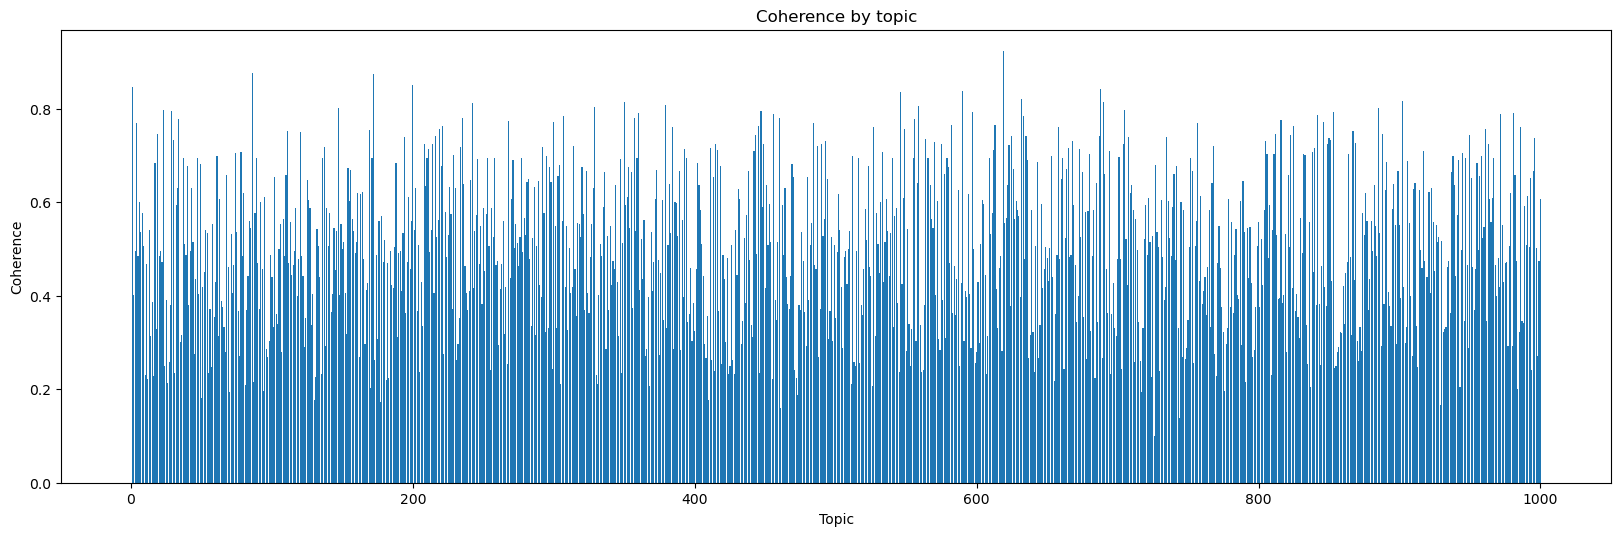

In [14]:
## %%script false --no-raise-error ## DO NOT UN-COMMENT THIS! THIS CELL IS NOT SUPPOSED TO RUN

topic_names = ['Topic '+str(i) for i in range(num_topics)]
try:
    coh_topics = coherence_model_lda.get_coherence_per_topic(segmented_topics=None,with_std=False, with_support=False)

    #for (i,tn) in enumerate(topic_names):
    #    print('Topic {0:2d}. Coherence: {1:6f}  {2:s}.  '.format(i+1,coh_topics[i],tn))
    
    fig, ax = plt.subplots(figsize=(20,6), dpi= 100, facecolor='w', edgecolor='k')
    x=np.arange(num_topics)+1
    plt.bar(x=x,height=coh_topics)
    plt.xlabel("Topic")
    plt.ylabel("Coherence")
    plt.title("Coherence by topic")
    plt.show()
except NameError:
    print('Coherence data not found')

## Read the Eurostat's database table of contents

* From the parsed table_of_contents.xml file, stored in the database.
* Keep only records - leaves, corresponding to datasets.
*    Column 'Normalized file description': from column 'File description' with the same pre-processing as the texts, i.e. tokenizing, keeping only non-stop alphanumeric tokens (but not numbers only), keeping tokens with minimum length 5 and finally lemmatization.
*    Column 'Normalized full path': as above from column 'Names'.
*    Create also 'Normalized file description - stems' and 'Normalized full path - stems' with the stems of the lemmas in the previous columns.

In [15]:
import ast

SQLCommand = """SELECT id, number, codes, names, file_descr, file_code, level 
                FROM ESTAT.V1.dat_all_datasets """

crumbs_df = pd.read_sql(SQLCommand,c)

crumbs_df['codes'] = crumbs_df['codes'].apply(lambda x: ast.literal_eval(x))
crumbs_df['names'] = crumbs_df['names'].apply(lambda x: ast.literal_eval(x))
crumbs_df.rename(columns={'number':'Number','codes':'Codes','names':'Names','file_descr':'File description','level':'Level','file_code':'File code'},inplace=True)
crumbs_df = crumbs_df[['Number','Names','File description','File code']]

## Keep only records - leaves, corresponding to datasets.
idx = crumbs_df[crumbs_df['File code']==''].index
crumbs_df.drop(index=idx, inplace=True) 
crumbs_df.reset_index(drop=True,inplace=True)

crumbs_df['Names']=crumbs_df['Names'].apply(lambda x: x[1:]) ## do not include top level

from nltk.stem import PorterStemmer
ps = PorterStemmer()

def list_to_words(sentence_list):
    tokens_list = []
    for sentence in sentence_list:
        tokens = lemmatize_text(sentence)
        tokens_list.extend(tokens)
    return tokens_list

crumbs_df['Normalized file description'] = crumbs_df['File description'].apply(lambda x: x.lower())
crumbs_df['Normalized file description'] = crumbs_df['Normalized file description'].apply(lambda x: lemmatize_text(x))
crumbs_df['Normalized file description - stems'] = crumbs_df['Normalized file description'].apply(lambda x: [ps.stem(w) for w in x])

crumbs_df['Normalized full path'] = crumbs_df['Names'].apply(lambda x: [y.lower() for y in x])
crumbs_df['Normalized full path'] = crumbs_df['Normalized full path'].apply(lambda x: list_to_words(x))
crumbs_df['Normalized full path - stems'] = crumbs_df['Normalized full path'].apply(lambda x: [ps.stem(w) for w in x])

#crumbs_df['source'] = 'dataset'

#crumbs_df.to_excel(outfile,index=False)
crumbs_df.insert(0, 'id', range(len(crumbs_df)))

crumbs_df


,id,Number,Names,File description,File code,Normalized file description,Normalized file description - stems,Normalized full path,Normalized full path - stems
0,0,1.1.1.1.1.1,"[General and regional statistics, European and...",Consumers - monthly data,ei_bsco_m,"[consumer, monthly]","[consum, monthli]","[general, regional, statistic, european, natio...","[gener, region, statist, european, nation, ind..."
1,1,1.1.1.1.1.2,"[General and regional statistics, European and...",Consumers - quarterly data,ei_bsco_q,"[consumer, quarterly]","[consum, quarterli]","[general, regional, statistic, european, natio...","[gener, region, statist, european, nation, ind..."
2,2,1.1.1.1.2.1,"[General and regional statistics, European and...",Industry - monthly data,ei_bsin_m_r2,"[industry, monthly]","[industri, monthli]","[general, regional, statistic, european, natio...","[gener, region, statist, european, nation, ind..."
3,3,1.1.1.1.2.2,"[General and regional statistics, European and...",Industry - quarterly data,ei_bsin_q_r2,"[industry, quarterly]","[industri, quarterli]","[general, regional, statistic, european, natio...","[gener, region, statist, european, nation, ind..."
4,4,1.1.1.1.2.3,"[General and regional statistics, European and...",Construction - monthly data,ei_bsbu_m_r2,"[construction, monthly]","[construct, monthli]","[general, regional, statistic, european, natio...","[gener, region, statist, european, nation, ind..."
...,...,...,...,...,...,...,...,...,...
8740,8740,4.8.6.3.3.8,"[Skills-related statistics, Skills development...",Students in tertiary education - as % of 20-24...,educ_uoe_enrt08,"[student, tertiary, education, year, population]","[student, tertiari, educ, year, popul]","[skill, related, statistic, skill, development...","[skill, relat, statist, skill, develop, partic..."
8741,8741,4.8.6.4.1,"[Skills-related statistics, Skills development...",Enterprises that provided training to develop/...,isoc_ske_ittn2,"[enterprise, provided, training, develop, upgr...","[enterpris, provid, train, develop, upgrad, sk...","[skill, related, statistic, skill, development...","[skill, relat, statist, skill, develop, partic..."
8742,8742,4.8.6.5.1,"[Skills-related statistics, Skills development...",Enterprises providing training by type of trai...,trng_cvt_01s,"[enterprise, providing, training, training, cl...","[enterpris, provid, train, train, class, enter...","[skill, related, statistic, skill, development...","[skill, relat, statist, skill, develop, partic..."
8743,8743,4.8.6.5.2,"[Skills-related statistics, Skills development...",Participants in CVT courses by sex and size cl...,trng_cvt_12s,"[participant, course, class, person, employed,...","[particip, cours, class, person, employ, enter...","[skill, related, statistic, skill, development...","[skill, relat, statist, skill, develop, partic..."


### The topics as a mix of keywords.

The above LDA model is built with 1000 different topics where each topic is a combination of keywords and each keyword contributes with a certain weight to the topic.  This mix of keywords (limited to the top 10 keywords) is shown below, for the first 10 topics.


In [16]:
for i in range(10):
    print(i,[(id2word[term_id],prob) for (term_id,prob) in lda_model.get_topic_terms(i,topn=10)],'\n')

0 [('import', 0.0875706), ('export', 0.07800472), ('south', 0.03642548), ('china', 0.035143897), ('billion', 0.028823411), ('russia', 0.027068356), ('turkey', 0.026934002), ('korea', 0.026621854), ('canada', 0.022524465), ('extra', 0.022163069)] 

1 [('young', 0.19475321), ('unemployment', 0.027115798), ('woman', 0.019439287), ('training', 0.016777158), ('death', 0.011865566), ('child', 0.010808026), ('neither', 0.008912256), ('limitation', 0.008518779), ('problem', 0.00802281), ('exclusively', 0.0075260787)] 

2 [('energy', 0.08980861), ('primary', 0.03059515), ('ukraine', 0.012907931), ('power', 0.0119502945), ('natural', 0.010793132), ('industry', 0.010483003), ('institution', 0.009686878), ('azerbaijan', 0.008875511), ('crime', 0.008735774), ('georgia', 0.008691137)] 

3 [('online', 0.07721558), ('purchase', 0.07283683), ('prior', 0.045429848), ('internet', 0.039537016), ('user', 0.034386046), ('accessory', 0.026574552), ('bought', 0.02567286), ('buying', 0.017677253), ('problem', 

### Import the saved word vectors

In [17]:
from gensim.models.keyedvectors import KeyedVectors

w_vectors = gensim.models.KeyedVectors.load_word2vec_format('SE_GL_wordvectors.txt', binary=False)

### Keep the top 10 keywords per topic and extend them with the closest words based on the word vectors

* List _words_: the unique lemmas from the topic modelling enhanced with their closest terms from the word vectors.
* List _used_words_: the subset of the above appearing in the full file descriptions.
* List _words_stems_: the corresponding stems in list _words_.
* List _used_words_stems_: the corresponding stems in list _used_words_.


In [18]:


words = set()

for topic_id in range(num_topics):
    #print('\nTopic id: ',topic_id+1 )
    ## top_words = [(a,b) for (a,b) in sorted(lda_model.show_topic(topic_id,topn=10),key=lambda x: x[1], reverse=True)]
    top_words = [a for (a,b) in lda_model.show_topic(topic_id,topn=10)]
    top_words += [lemmatizer.lemmatize(w_vectors.most_similar(tok)[0][0]) for tok in top_words if tok in w_vectors.key_to_index]
    words.update(top_words)    

print('topic modelling words and similar:',len(words))
used_words = [word for word in words if any(crumbs_df['Normalized full path'].apply(lambda x: 1 if word in x else 0))]
print('of which appear in the full file descriptions: ',len(used_words))

words_stems = set([ps.stem(w) for w in words])
print('topic modelling words and similar - corresponding stems:',len(words_stems))
used_words_stems = [s for s in words_stems if any(crumbs_df['Normalized full path - stems'].apply(lambda x: 1 if s in x else 0))]

print('of which appear in the full file descriptions: ',len(used_words_stems))



topic modelling words and similar: 2806
of which appear in the full file descriptions:  1321
topic modelling words and similar - corresponding stems: 2182
of which appear in the full file descriptions:  1235


### Optional: Create a file with multi-labels for use in other codes

In [19]:
col_list = sorted(used_words)
#print(col_list)
tmp = np.zeros((len(crumbs_df),len(col_list)))
for i in range(len(col_list)):
    tmp[:,i] = crumbs_df['Normalized full path'].apply(lambda x: 1 if col_list[i] in x else 0)
tmp = pd.DataFrame(tmp,columns=col_list,dtype='int')    
tmp = pd.concat([crumbs_df,tmp],axis=1)  
tmp.to_excel('tmp.xlsx')
tmp

,id,Number,Names,File description,File code,Normalized file description,Normalized file description - stems,Normalized full path,Normalized full path - stems,ability,...,workforce,workplace,workstation,would,written,yearly,yield,young,youngest,youth
0,0,1.1.1.1.1.1,"[General and regional statistics, European and...",Consumers - monthly data,ei_bsco_m,"[consumer, monthly]","[consum, monthli]","[general, regional, statistic, european, natio...","[gener, region, statist, european, nation, ind...",0,...,0,0,0,0,0,0,0,0,0,0
1,1,1.1.1.1.1.2,"[General and regional statistics, European and...",Consumers - quarterly data,ei_bsco_q,"[consumer, quarterly]","[consum, quarterli]","[general, regional, statistic, european, natio...","[gener, region, statist, european, nation, ind...",0,...,0,0,0,0,0,0,0,0,0,0
2,2,1.1.1.1.2.1,"[General and regional statistics, European and...",Industry - monthly data,ei_bsin_m_r2,"[industry, monthly]","[industri, monthli]","[general, regional, statistic, european, natio...","[gener, region, statist, european, nation, ind...",0,...,0,0,0,0,0,0,0,0,0,0
3,3,1.1.1.1.2.2,"[General and regional statistics, European and...",Industry - quarterly data,ei_bsin_q_r2,"[industry, quarterly]","[industri, quarterli]","[general, regional, statistic, european, natio...","[gener, region, statist, european, nation, ind...",0,...,0,0,0,0,0,0,0,0,0,0
4,4,1.1.1.1.2.3,"[General and regional statistics, European and...",Construction - monthly data,ei_bsbu_m_r2,"[construction, monthly]","[construct, monthli]","[general, regional, statistic, european, natio...","[gener, region, statist, european, nation, ind...",0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8740,8740,4.8.6.3.3.8,"[Skills-related statistics, Skills development...",Students in tertiary education - as % of 20-24...,educ_uoe_enrt08,"[student, tertiary, education, year, population]","[student, tertiari, educ, year, popul]","[skill, related, statistic, skill, development...","[skill, relat, statist, skill, develop, partic...",0,...,0,0,0,0,0,0,0,0,0,0
8741,8741,4.8.6.4.1,"[Skills-related statistics, Skills development...",Enterprises that provided training to develop/...,isoc_ske_ittn2,"[enterprise, provided, training, develop, upgr...","[enterpris, provid, train, develop, upgrad, sk...","[skill, related, statistic, skill, development...","[skill, relat, statist, skill, develop, partic...",0,...,0,0,0,0,0,0,0,0,0,0
8742,8742,4.8.6.5.1,"[Skills-related statistics, Skills development...",Enterprises providing training by type of trai...,trng_cvt_01s,"[enterprise, providing, training, training, cl...","[enterpris, provid, train, train, class, enter...","[skill, related, statistic, skill, development...","[skill, relat, statist, skill, develop, partic...",0,...,0,0,0,0,0,0,0,0,0,0
8743,8743,4.8.6.5.2,"[Skills-related statistics, Skills development...",Participants in CVT courses by sex and size cl...,trng_cvt_12s,"[participant, course, class, person, employed,...","[particip, cours, class, person, employ, enter...","[skill, related, statistic, skill, development...","[skill, relat, statist, skill, develop, partic...",0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
import ipywidgets as widgets
from ipywidgets import Layout
layout = widgets.Layout(width='600px', height='60px')

In [21]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [22]:
from IPython.display import HTML, display,clear_output

## Run once the chunk below then just change inputs

* Find both types of matches:
    * i) Using only the lemmas (or stems) from the query, which belong to the enhanced topic modelling vocabulary.
    * ii) Using all lemmas (or stems) from the query.    
    * Sort the results first by the number of matches in (i), then by the number of matches in (ii), so that the most significant matches have priority.
* Using the stems of the lemmas is an option to circumvent weaknesses in the lemmatizer which in some cases leave different forms of the same word as separate lemmas.    

In [23]:
import eurostat
#import qgrid

## below not used here
codes = {'hazard': 16, 'time': 1169, 'nace_r1': 888, 'geo': 4017, 
    'age691': None, 'rbd': 412, 'time1': None, 'nace_r2': 1298, 
    'worktime': 31, 'metroreg': 422, 'geo91': None, 'injury': 50, 'physact': 22, 'ceparema': 37, 
    'modinj': 11, 'train': 12, 'wrkenv': 15, 'frequenc': 61, 'tra_cov': 32, 'stk_flow': 190, 'par_mar': 302, 
    'currency': 193, 'cities': 13507, 'indic_env': 81, 'emp_cont': 17, 'loadstat': 3, 'size_emp': 31, 'airp_pr': 25160, 
    'unit': 668, 'nst07': 104, 'wat_proc': 56, 'comspec': 3, 'sex': 7, 'time91': None, 'age': 651, 
    'workproc': 9, 'age91': None, 'citizen': 4017, 'port_iww': 1032, 'source': 14, 'c_cabot': 4017, 
    'wrkstat': 5, 'c_birth': 4017, 'rep_airp': 1116, 'deviatn': 11, 'matagent': 23, 'diagnose': 28, 
    'rep_mar': 1842, 'partner': 4017, 'c_regis': 4017, 'geo1': None, 'seabasin': 12}
        

def relevant_datasets(Sentences,option,use_s_option,howmany,show_meta,show_meta_ind):
   
    tokens_list = lemmatize_text(Sentences)
    h = '<h3>Initial tokens:</h3>'
    h += '  '.join('[' + x + ']' for x in tokens_list)
    h += '<h3>Similarity-enhanced tokens:</h3>'
    
    ## initial list of entered lemmas together with lemmas of most similar words
    tokens_list += [lemmatizer.lemmatize(w_vectors.most_similar(tok)[0][0]) for tok in tokens_list if tok in w_vectors.key_to_index]
    tokens_list = list(set(tokens_list))
    
    ## corresponding stems
    tokens_list_stems = list(set([ps.stem(tok) for tok in tokens_list]))

    h += '  '.join('[' + x + ']' for x in tokens_list)+'<br/>'   
    h += '<h3>Of these, tokens in the TM vocabulary which appear in the datasets full descriptions:</h3>'
    
    ## terms in tokens_list actually used in the full file descriptions 
    tokens_list_enhanced=[tok for tok in tokens_list if tok in used_words] 

    ## corresponding stems
    tokens_list_enhanced_stems = list(set([ps.stem(tok) for tok in tokens_list_enhanced]))

    h += '  '.join('[' + x + ']' for x in tokens_list_enhanced)+'<br/>'  
    #print('found in keywords used in datasets: ',common)
    h += '<h3>Datasets descriptions in descending order of tokens found - top '+str(howmany)+':</h3>'
    

    res2 = crumbs_df.copy()
    if option==1: ## use the Normalized file description
        if use_s_option == 1: ## with stemming
            res2['Words found s2'] = res2['Normalized file description - stems'].apply(lambda x: list(set([y for y in x if y in tokens_list_enhanced_stems])))
            res2['Number s2'] = res2['Normalized file description - stems'].apply(lambda x: len(set([y for y in x if y in tokens_list_enhanced_stems])))

            res2['Words found s1'] = res2['Normalized file description - stems'].apply(lambda x: list(set([y for y in x if y in tokens_list_stems])))
            res2['Number s1'] = res2['Normalized file description - stems'].apply(lambda x: len(set([y for y in x if y in tokens_list_stems])))
        else: ## no stemming
            res2['Words found s2'] = res2['Normalized file description'].apply(lambda x: list(set([y for y in x if y in tokens_list_enhanced])))
            res2['Number s2'] = res2['Normalized file description'].apply(lambda x: len(set([y for y in x if y in tokens_list_enhanced])))

            res2['Words found s1'] = res2['Normalized file description'].apply(lambda x: list(set([y for y in x if y in tokens_list])))
            res2['Number s1'] = res2['Normalized file description'].apply(lambda x: len(set([y for y in x if y in tokens_list])))
        
        res2.sort_values(by=['Number s2','Number s1'], axis=0, ascending=False, inplace=True)
        res2 = res2.loc[(res2['Number s2']>=1) | (res2['Number s1']>=1)]
        res2 = res2[['id','File description','File code','Words found s2','Number s2','Words found s1','Number s1']] ## corresponding records from crumbs_df
        
    else: ## use the Normalized full path   
        if use_s_option == 1: ## with stemming
            res2['Words found f2'] = res2['Normalized full path - stems'].apply(lambda x: list(set([y for y in x if y in tokens_list_enhanced_stems])))
            res2['Number f2'] = res2['Normalized full path - stems'].apply(lambda x: len(set([y for y in x if y in tokens_list_enhanced_stems])))

            res2['Words found f1'] = res2['Normalized full path - stems'].apply(lambda x: list(set([y for y in x if y in tokens_list_stems])))
            res2['Number f1'] = res2['Normalized full path - stems'].apply(lambda x: len(set([y for y in x if y in tokens_list_stems])))
        else: ## no stemming
            res2['Words found f2'] = res2['Normalized full path'].apply(lambda x: list(set([y for y in x if y in tokens_list_enhanced])))
            res2['Number f2'] = res2['Normalized full path'].apply(lambda x: len(set([y for y in x if y in tokens_list_enhanced])))

            res2['Words found f1'] = res2['Normalized full path'].apply(lambda x: list(set([y for y in x if y in tokens_list])))
            res2['Number f1'] = res2['Normalized full path'].apply(lambda x: len(set([y for y in x if y in tokens_list])))
    
        res2.sort_values(by=['Number f2','Number f1'], axis=0, ascending=False, inplace=True)
        res2 = res2.loc[(res2['Number f2']>=1) | (res2['Number f1']>=1)]
        res2 = res2[['id','File description','File code','Words found f2','Number f2','Words found f1','Number f1']] ## corresponding records from crumbs_df
    
    res2.reset_index(drop=True,inplace=True)
    res2.rename(columns={'index':'Dataset id'},inplace=True)
    
    if len(res2) == 0:
        h += 'No datasets found'+'<br/>'  
        display(HTML(h))
    else:
        display(HTML(h))
        res2.to_excel('res2.xlsx')
        if len(res2) < howmany:
            howmany = len(res2)
        res2 = res2.iloc[:howmany]

        for i in range(len(res2)):
            url='https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?sort=1&file=data%2F'+res2.loc[i,'File code']+'.tsv.gz'
            res2.loc[i,'Link'] = url
        
        display(HTML(res2.to_html()))
    
        if show_meta and len(res2)>0:

            dst = pd.read_csv(res2.loc[show_meta_ind,'Link'],sep='\t',low_memory=False)
            dcode=res2.loc[show_meta_ind,'File code']
            dms = eurostat.get_sdmx_dims(dcode)
            h1 = '<h3>'+str(show_meta_ind)+': File code: '+dcode+'</h3>'
            h1 += '<h3>'+res2.loc[show_meta_ind,'File description']+'</h3>'
            h1 += '<h3>Dimensions:</h3>'
            h1 += '  '.join('[' + x + ']' for x in dms)

            h2=''
            dims=dst.columns[0].split(',')
            dims = dims[:-1]+dims[-1].split('\\')
        
            tmp=dst.iloc[:,0].str.split(',',expand=True)
            for j in range(len(dims)-2): ## first the dimensions separated by comma
                if dims[j] not in codes.keys() or codes[dims[j]] != None:
                    h2+='<h4>'+dims[j]+':</h4>'
                    arr = pd.unique(tmp.iloc[:,j])
                    for i in range(len(arr)):
                        h2+= '[ '+arr[i]+': '+eurostat.get_dic(dims[j])[arr[i]] +' ]'
            display(HTML(h1))
            display(HTML(h2))            
            display(HTML(dst.head().to_html()))

## Run once the chunk below then just change inputs

In [24]:
def relevant_datasets_to_text(): 
    
    first_text = 'In 2021 unemployment among young people in Greece increased. This was the result of recession over the last 10 years.'  
    style = {'description_width': 'initial'}
    
    textW = widgets.Textarea(
        value=first_text, 
        placeholder='Type something',
        description='',
        disabled=False,
        layout=Layout(width='90%', height='100px')
    )

    button = widgets.Button(description="Search")
    
    option = widgets.RadioButtons(
    options=['Simple description of datasets', 'Full-path description of datasets'],
    value='Full-path description of datasets', 
    layout={'width': 'max-content'}, 
    disabled=False
    )    
    
    howmany = widgets.IntSlider(
        description='Display:',
        #tooltip='maximum:',
        value=20,
        min=1, 
        max = 30,
        style=style )
    howmany.style.handle_color = 'lightblue'
    
    show_more = widgets.Checkbox(
        value=True,
        description='Show metadata for row:',
        disabled=False,
        indent=True
     )
    
    use_stems = widgets.Checkbox(
        value=True,
        description='Use stems',
        disabled=False,
        indent=True
    )
    
    select_ind = widgets.BoundedIntText(
        value=0,
        min=0,
        max=howmany.value-1,
        step=1,
        description='Row:',
        disabled=False,
        style={'description_width': 'initial'},
        layout = widgets.Layout(width='100px')
    )

    

    ui1=widgets.HBox([textW])
    ui2=widgets.HBox([option,button,howmany])
    ui3=widgets.HBox([show_more,select_ind,use_stems])
    ui4=widgets.VBox([ui1,ui2,ui3])
    display(ui4, layout=Layout(align_items='center'))

    def on_button_clicked(b):
        clear_output()
        display(ui4, layout=Layout(align_items='center'))
        if option.value == 'Simple description of datasets':
            opt_val = 1
        else:
            opt_val = 2
        if use_stems.value == True:
            use_s_opt  = 1
        else:
            use_s_opt  = 2
        relevant_datasets(textW.value,option=opt_val,use_s_option=use_s_opt,howmany=howmany.value,show_meta=show_more.value,show_meta_ind=select_ind.value)
       
    button.on_click(on_button_clicked)
    
    
relevant_datasets_to_text()
   

,id,File description,File code,Words found f2,Number f2,Words found f1,Number f1,Link
0,2312,"Unemployment rates of young people not in education and training by sex, educational attainment level and years since completion of highest level of education",edat_lfse_25,"[young, unemploy]",2,"[year, young, peopl, unemploy]",4,https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?sort=1&file=data%2Fedat_lfse_25.tsv.gz
1,3107,Average age when leaving formal education by sex and educational attainment level for persons who left within the last 3 or 5 years,edat_lfso_09t1,"[young, unemploy]",2,"[year, peopl, young, unemploy]",4,https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?sort=1&file=data%2Fedat_lfso_09t1.tsv.gz
2,3108,"Average time between leaving formal education and starting the first job by age, sex and educational attainment level for persons who left within the last 3 or 5 years - (months)",edat_lfso_09t2,"[young, unemploy]",2,"[year, peopl, young, unemploy]",4,https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?sort=1&file=data%2Fedat_lfso_09t2.tsv.gz
3,3109,"Employment rates by age, sex, educational attainment level and number of years after leaving formal education",edat_lfso_09t3,"[young, unemploy]",2,"[year, peopl, young, unemploy]",4,https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?sort=1&file=data%2Fedat_lfso_09t3.tsv.gz
4,3168,Number of persons between 15 and 64 years old regularly taking care of other children up to 14 or people older than 15 in need of care,lfso_05regcp,"[older, unemploy]",2,"[year, peopl, older, unemploy]",4,https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?sort=1&file=data%2Flfso_05regcp.tsv.gz
5,7400,Young people neither in employment nor in education and training (15-24 years) - % of the total population in the same age group,tipslm90,"[young, unemploy]",2,"[year, peopl, young, unemploy]",4,https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?sort=1&file=data%2Ftipslm90.tsv.gz
6,2318,Youth transitions from education to working life in Europe (in number of months),edat_lfso_00t1,"[youth, young]",2,"[youth, young, peopl]",3,https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?sort=1&file=data%2Fedat_lfso_00t1.tsv.gz
7,2552,"Young people neither in employment nor in education and training (NEET), by sex and age - annual data",lfsi_neet_a,"[young, unemploy]",2,"[peopl, young, unemploy]",3,https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?sort=1&file=data%2Flfsi_neet_a.tsv.gz
8,2553,"Young people neither in employment nor in education and training (NEET), by sex and age - quarterly data",lfsi_neet_q,"[young, unemploy]",2,"[peopl, young, unemploy]",3,https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?sort=1&file=data%2Flfsi_neet_q.tsv.gz
9,2565,"Young people neither in employment nor in education and training (NEET) (2006-2020), by sex and age - annual data",lfsi_neet_a_h,"[young, unemploy]",2,"[peopl, young, unemploy]",3,https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?sort=1&file=data%2Flfsi_neet_a_h.tsv.gz


,"duration,isced11,age,sex,unit,geo\time",2020,2019,2018,2017,2016,2015,2014,2013,2012,2011,2010,2009,2008,2007,2006,2005,2004,2003,2002,2001,2000
0,"TOTAL,ED0-2,Y15-34,F,PC,AT",22.0,18.9,19.6,22.4,22.3,23.3,21.2 b,20.4,23.0,20.9,20.0,22.8,20.3,17.7 b,18.3 b,21.0,22.0 b,11.8,13.5,9.9,12.4
1,"TOTAL,ED0-2,Y15-34,F,PC,BE",23.6,20.1,22.7,34.2 b,28.2,32.1,30.8 b,29.5,30.1,29.1 b,29.2,30.8,29.2 b,28.4,27.1 b,31.5,29.2 b,30.6,23.5,21.7 b,22.9
2,"TOTAL,ED0-2,Y15-34,F,PC,BG",23.0 u,: u,24.2 u,21.6 u,26.0 u,31.8 u,37.5 b,31.8,37.3,35.9 b,32.1 b,21.0,18.2 bu,24.9,33.4 b,29.3,30.2,32.1 b,40.2,46.3,:
3,"TOTAL,ED0-2,Y15-34,F,PC,CH",23.5,13.3 u,19.2,18.3,20.9,20.1,19.7 b,15.4,19.4,16.5,19.4 b,19.9,11.5 u,15.4,15.8,20.5,18.4,13.6 b,4.7 u,6.2 u,: u
4,"TOTAL,ED0-2,Y15-34,F,PC,CY",11.5 u,: u,12.7 u,19.8 u,22.0 u,20.2 u,10.5 bu,16.6 u,12.5 u,: u,7.5 u,7.6 bu,7.9 u,8.3 u,7.8 bu,9.1 u,15.0,9.8 bu,: u,5.9 u,11.2 u
